In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

import numpy as np

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data clust
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


Shape of rotated_x_train: (152400, 28, 28)
Shape of rotated_y_train: (152400,)
Shape of rotated_x_test: (26004, 28, 28)
Shape of rotated_y_test: (26004,)


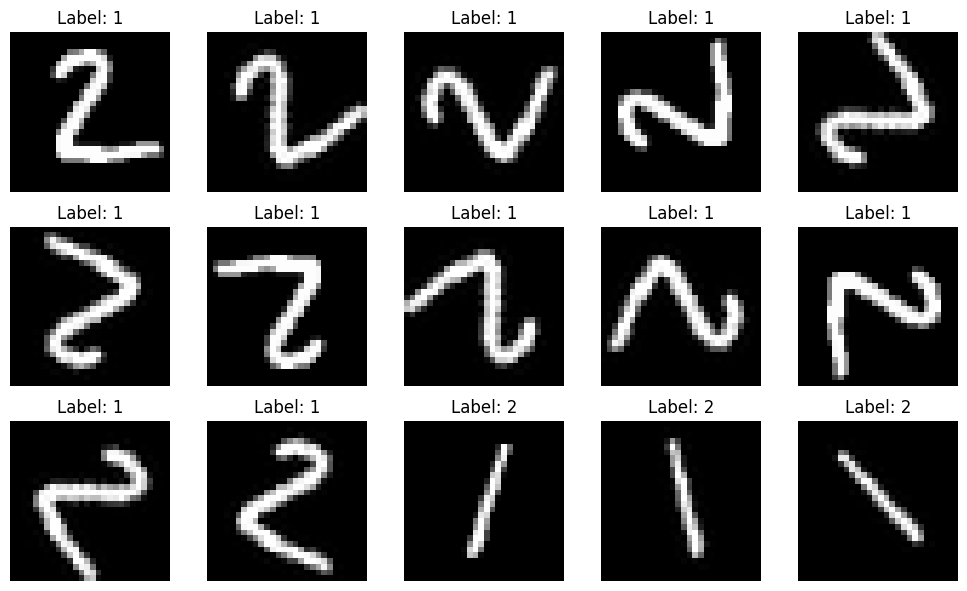

In [4]:

import matplotlib.pyplot as plt

# Display the first 15 images from x_test
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    if i < 15:
        ax.imshow(rotated_x_test[i], cmap='gray')
        ax.set_title(f"Label: {rotated_y_test[i]}")
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


In [5]:
!pip install tensorflow

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

#VAE (LS=32)

In [7]:


# Load the rotated MNIST dataset
# Assuming 'rotated_mnist.npz' contains 'x_train', 'y_train', 'x_test', 'y_test'
# data = np.load('rotated_mnist.npz')
# rotated_x_train = data['x_train']
# rotated_y_train = data['y_train']
# rotated_x_test = data['x_test']
# rotated_y_test = data['y_test']


rotated_x_train = rotated_x_train.astype("float32") / 255.0
rotated_x_test = rotated_x_test.astype("float32") / 255.0
rotated_x_train = np.expand_dims(rotated_x_train, -1)
rotated_x_test = np.expand_dims(rotated_x_test, -1)


latent_dim = 32  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(rotated_x_train, epochs=20, batch_size=128)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │            544 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │            544 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,096 (273.81 KB)

 Trainable params: 70,096 (273.81 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │         103,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - kl_loss: 9.2365 - loss: 196.1684 - reconstruction_loss: 186.9319
Epoch 2/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 15.0088 - loss: 122.5902 - reconstruction_loss: 107.5814
Epoch 3/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 13.6245 - loss: 115.1654 - reconstruction_loss: 101.5410
Epoch 4/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 13.2742 - loss: 112.0060 - reconstruction_loss: 98.7318
Epoch 5/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 13.3054 - loss: 110.7363 - reconstruction_loss: 97.4308
Epoch 6/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 13.3420 - loss: 109.5479 - reconstruction_loss: 96.2060
Epoch 7/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 13.4169 - loss: 108.9686 - reconstruction_loss: 95.5516
Epoch 8/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 13.4705 - loss: 108.6397 - reconstruction_loss: 95.1692
Epoch 9/20
1191/1191 ━━━━━━━━

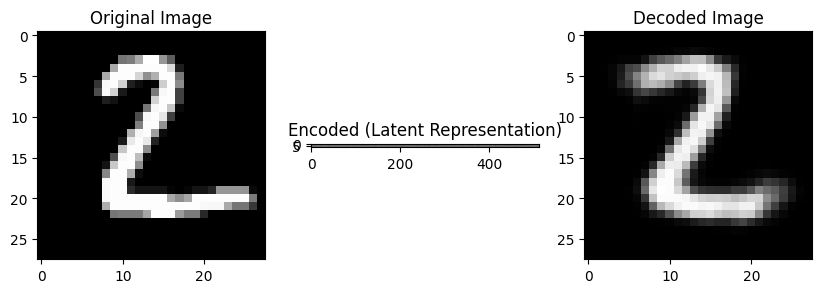

In [8]:
import matplotlib.pyplot as plt

original_image = rotated_x_test[0]

# Assuming rotated_x_test is already loaded
batch_size = 128
batch_indices = np.arange(batch_size)
batch_images = rotated_x_test[batch_indices]

# Encode the batch of images
z_mean, z_log_var, z = vae.encoder(batch_images)
# Decode the encoded representation
decoded_image = vae.decoder(z).numpy()

# Display the original, encoded, and decoded images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
z_mean_reshaped = z_mean.numpy().reshape(8, -1)
plt.imshow(z_mean_reshaped, cmap='gray')
plt.title('Encoded (Latent Representation)')

plt.subplot(1, 3, 3)
# Display only the first image from the decoded batch
plt.imshow(decoded_image[0].squeeze(), cmap='gray')
plt.title('Decoded Image')

plt.show()

In [11]:
vae.encoder.save_weights("/content/drive/MyDrive/GSOC/GSOC/encoder_weights.weights.h5")
vae.decoder.save_weights("/content/drive/MyDrive/GSOC/GSOC/decoder_weights.weights.h5")

In [19]:

latent_dim = 32  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3136)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │         50,192 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │            544 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │            544 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,096 (273.81 KB)

 Trainable params: 70,096 (273.81 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3136)                │         103,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Loading:
encoder = encoder #Use the original encoder definition.
decoder = decoder #Use the original decoder definition.
vae = VAE(encoder, decoder)

# Load weights:
encoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/encoder_weights.weights.h5")
decoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/decoder_weights.weights.h5")

print("VAE weights loaded, model reconstructed.")

VAE weights loaded, model reconstructed.


#SUPERVISED MLP

In [22]:

import numpy as np

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data clust
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


Shape of rotated_x_train: (152400, 28, 28)
Shape of rotated_y_train: (152400,)
Shape of rotated_x_test: (26004, 28, 28)
Shape of rotated_y_test: (26004,)


In [23]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.ndimage import rotate



# Loading the original data (1 and 2 digits only)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_indices = np.where((y_train == 1) | (y_train == 2))[0]
x_train = x_train[train_indices]

def rotate_images(images, angles):
    rotated_images = []
    for image in images:
        for angle in angles:
            rotated_image = rotate(image, angle, reshape=False, mode='nearest')
            rotated_images.append(rotated_image)
    return np.array(rotated_images)

# Define rotation angles (same as before)
angles = [30 * i for i in range(12)]


rotated_x_train_for_original = rotate_images(x_train, angles)


rotated_x_train_for_original = rotated_x_train_for_original.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
rotated_x_train = rotated_x_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

# Get latent representations
z_original = vae.encoder.predict(rotated_x_train_for_original)[2]
z_rotated_train = vae.encoder.predict(rotated_x_train)[2]

latent_dim = z_original.shape[1]

class RotatedLatentDataLoader(tf.keras.utils.Sequence):
    def __init__(self, z_original, z_rotated_train, batch_size):
        self.z_original = z_original
        self.z_rotated_train = z_rotated_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.z_original) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.z_original[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.z_rotated_train[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

# Create MLP
mlp_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(mlp_inputs)
x = layers.Dense(32, activation='relu')(x)
mlp_outputs = layers.Dense(latent_dim)(x)

mlp = keras.Model(mlp_inputs, mlp_outputs, name='symmetry_mlp')
mlp.summary()

train_data_loader = RotatedLatentDataLoader(z_original, z_rotated_train, 128)

# Train MLP
mlp.compile(optimizer='adam', loss='mse')
mlp.fit(train_data_loader, epochs=5, verbose=1)

4763/4763 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
4763/4763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


Model: "symmetry_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,248 (20.50 KB)

 Trainable params: 5,248 (20.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8894
Epoch 2/5
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7853
Epoch 3/5
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7841
Epoch 4/5
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7838
Epoch 5/5
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7840


In [29]:
data = np.load('/content/rotated_mnist (1).npz')
rotated_x_test = data['x_test']

# Load the original test set (digits 1 and 2 only)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
test_indices = np.where((y_test == 1) | (y_test == 2))[0]
x_test = x_test[test_indices]

# Define rotation angles (same as before)
angles = [30 * i for i in range(12)]


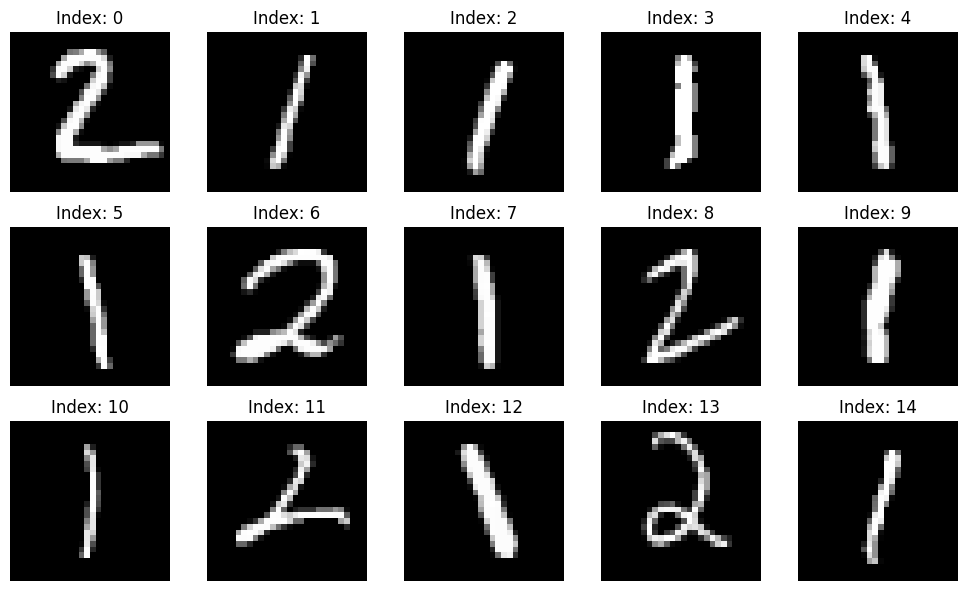

In [30]:
import matplotlib.pyplot as plt


# Display the first 15 images from x_test
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    if i < 15:
        ax.imshow(x_test[i].squeeze(), cmap='gray')
        ax.set_title(f"Index: {i}")
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


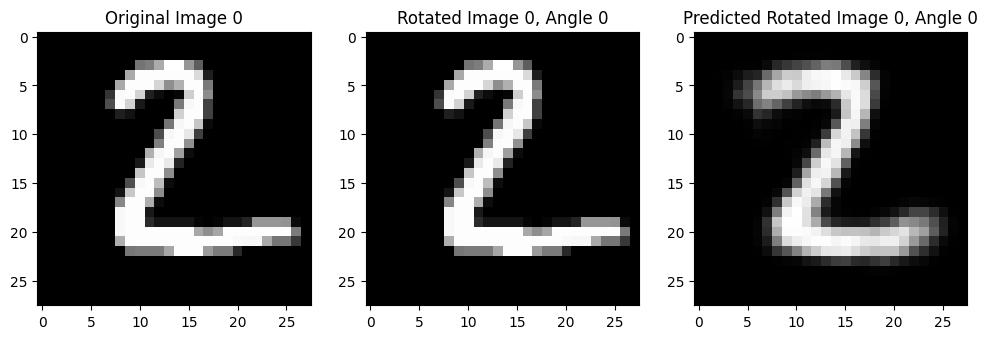

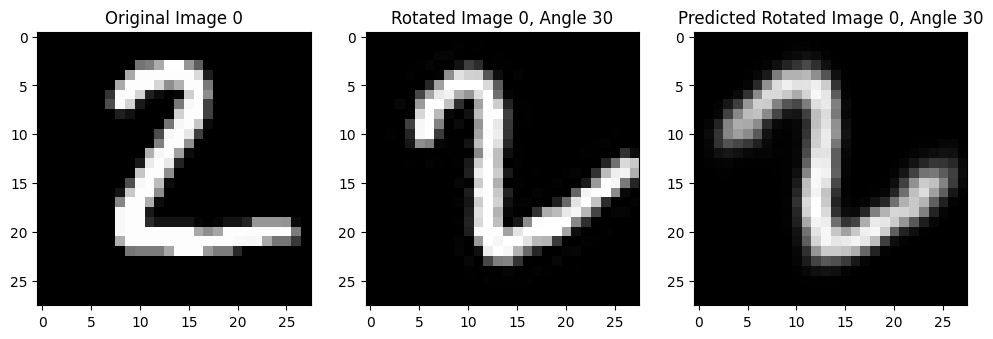

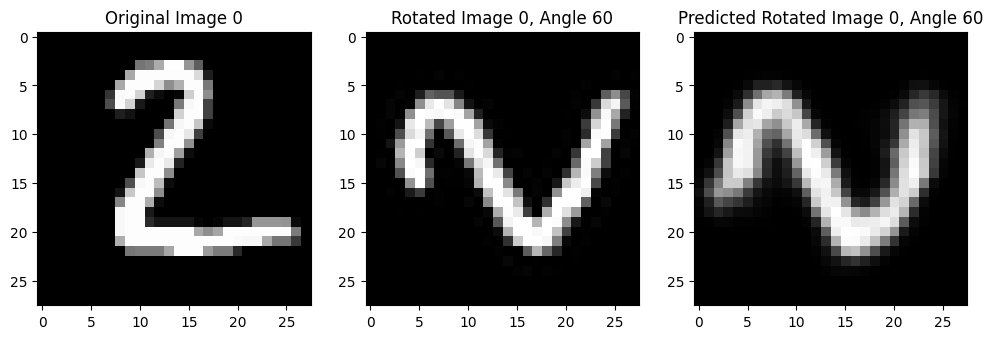

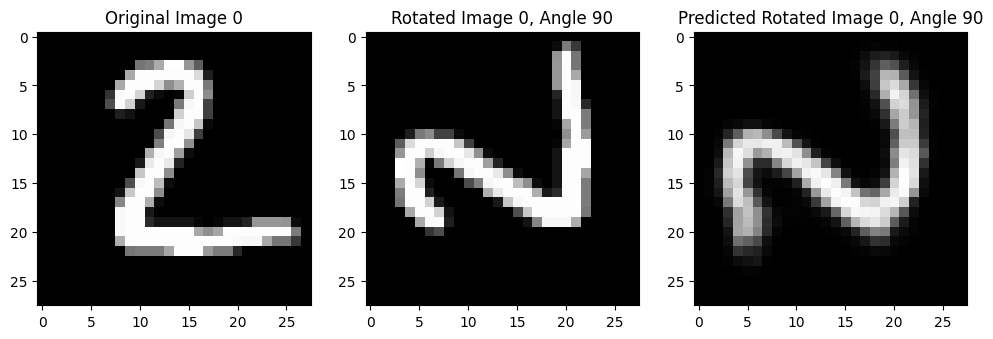

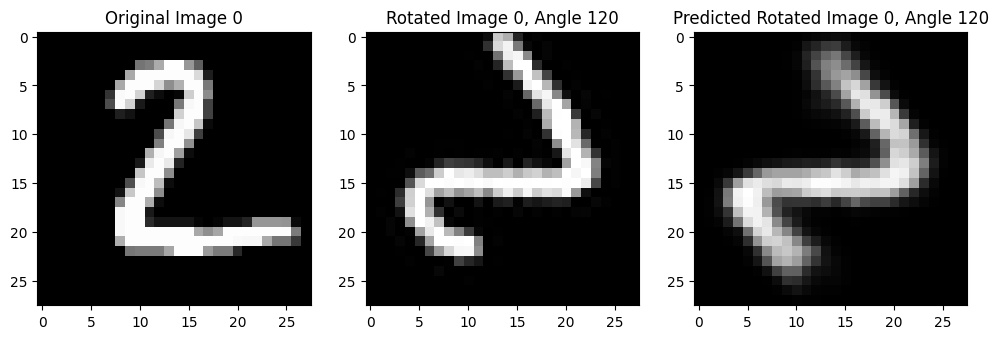

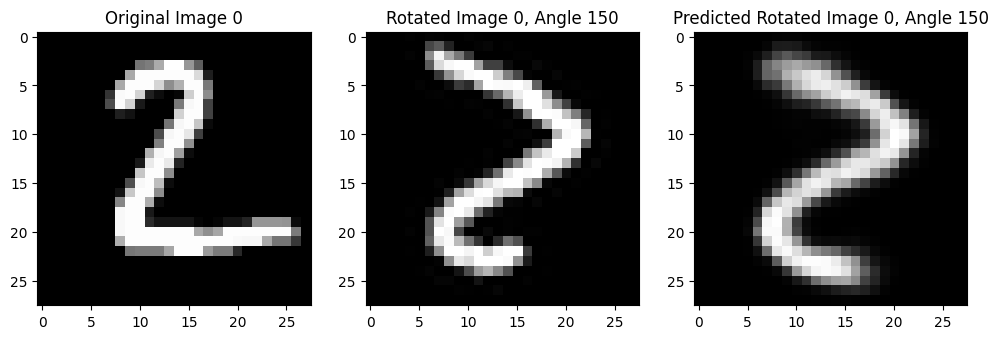

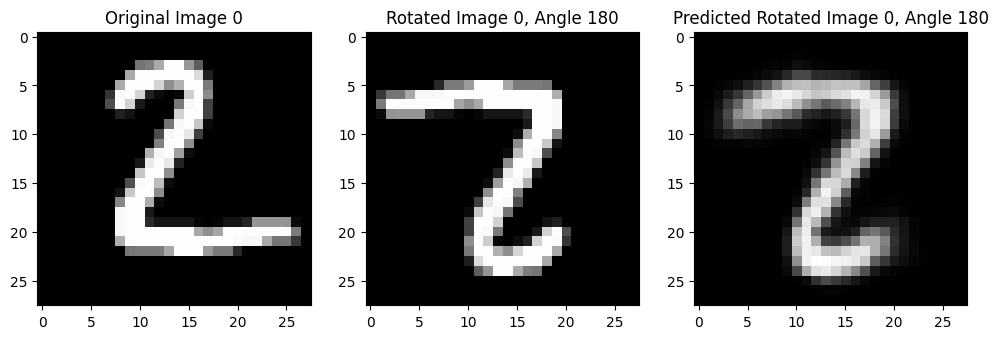

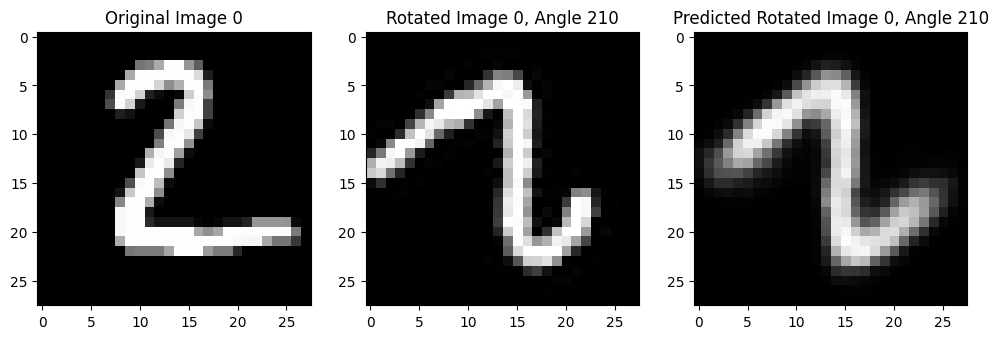

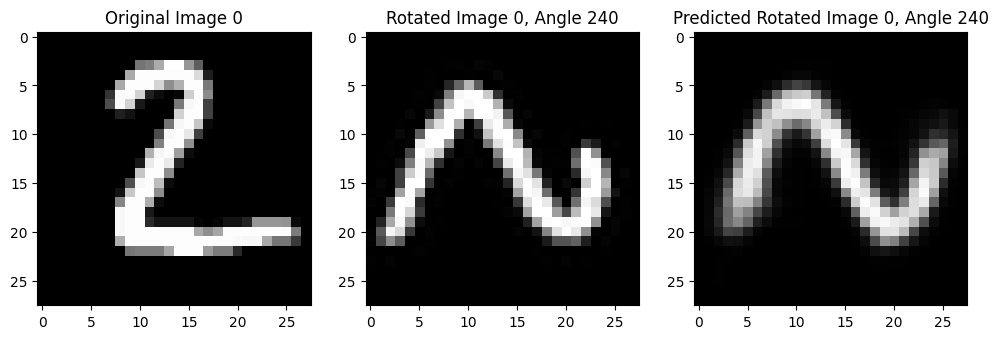

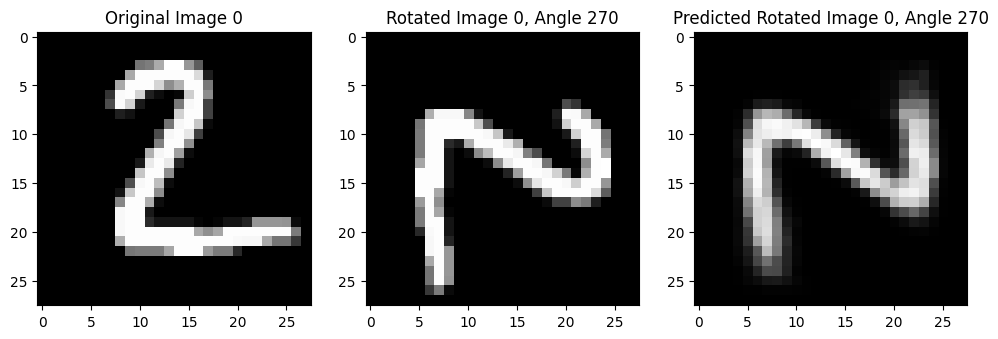

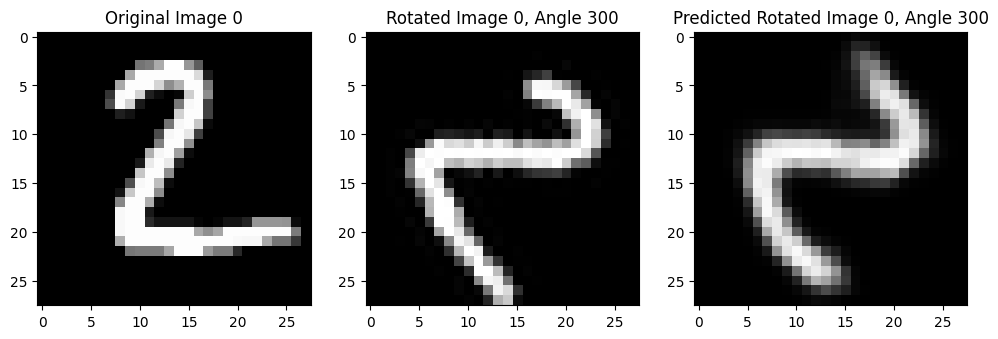

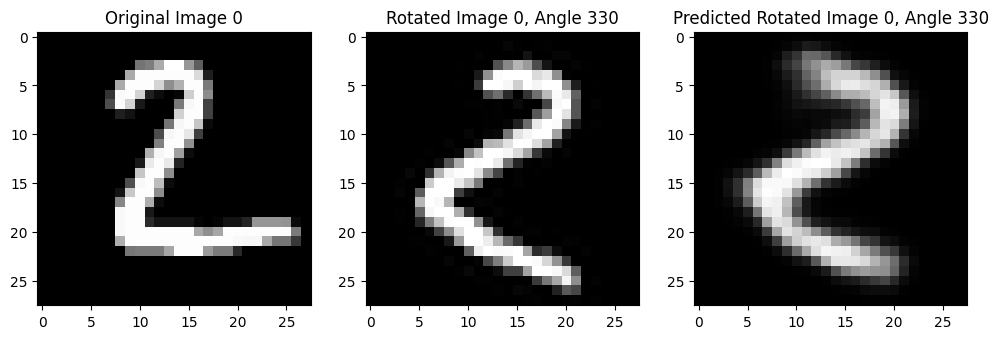

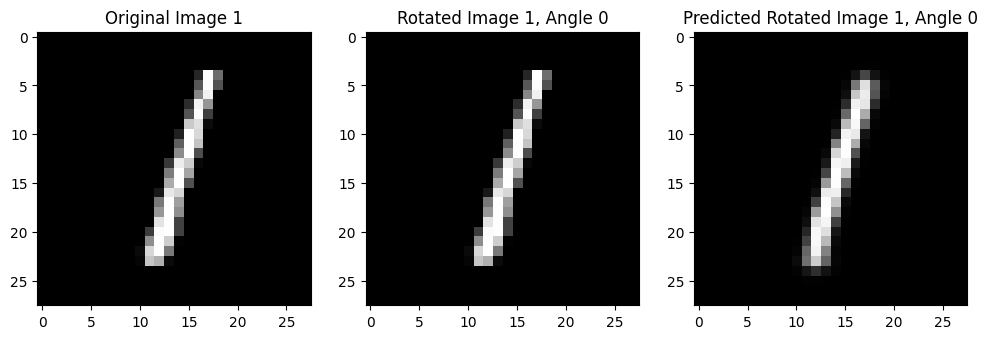

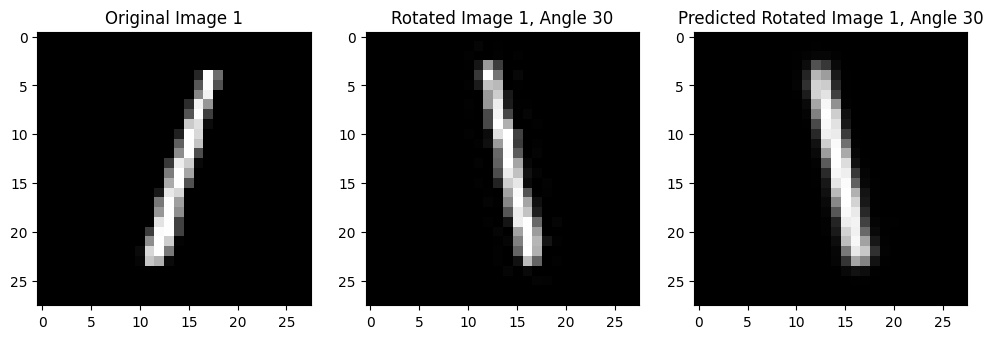

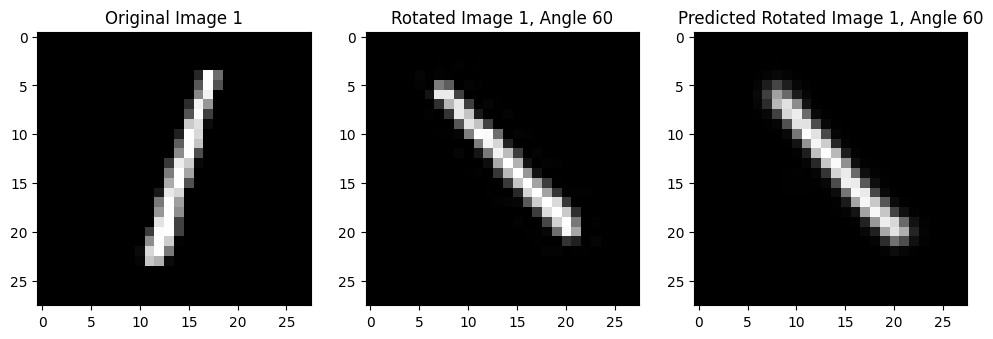

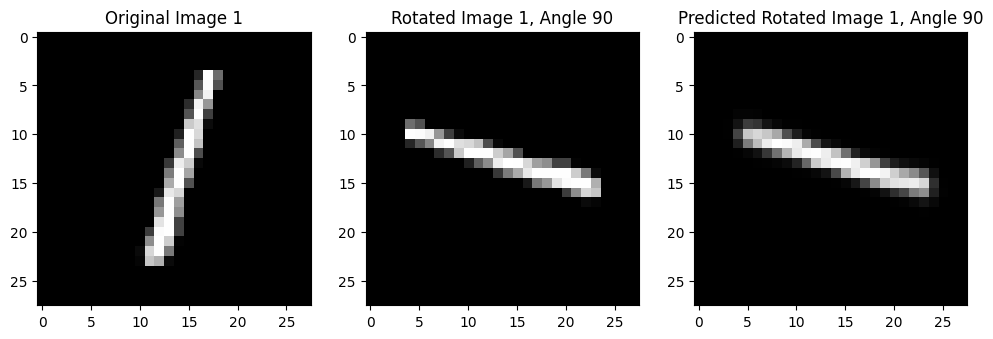

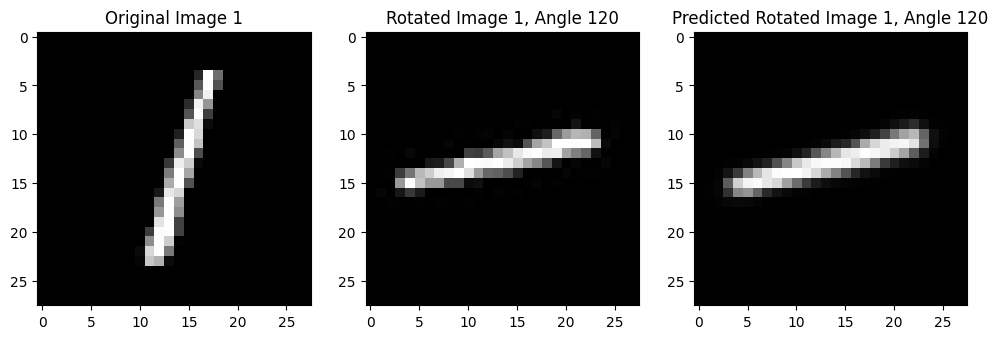

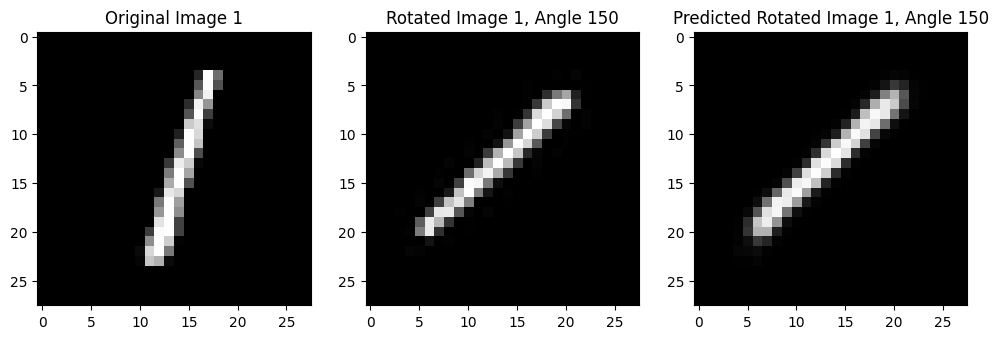

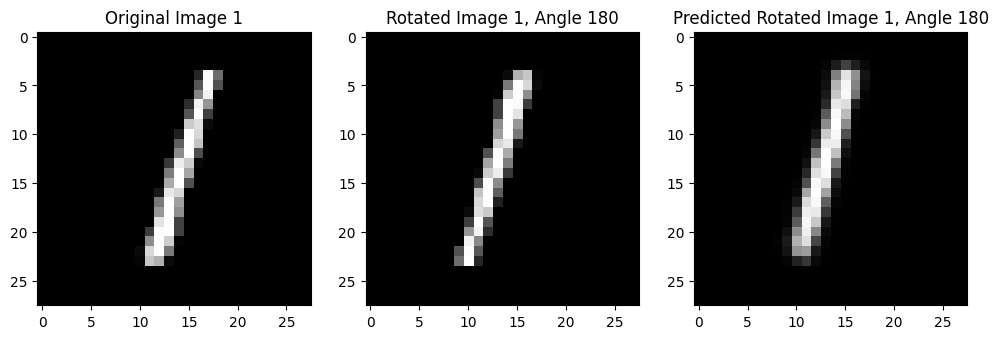

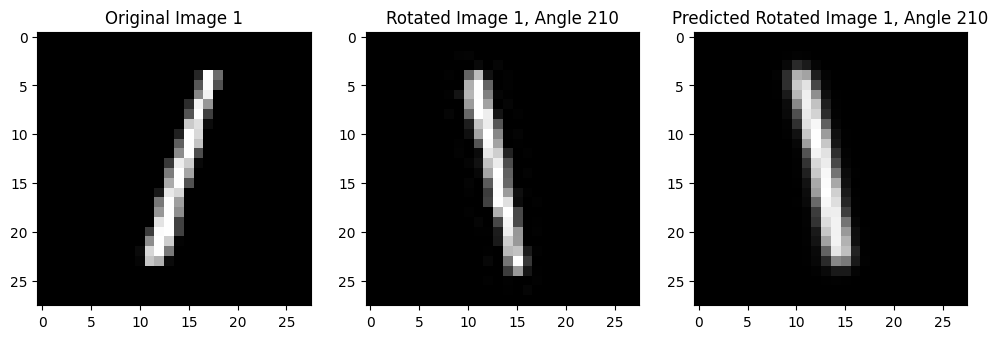

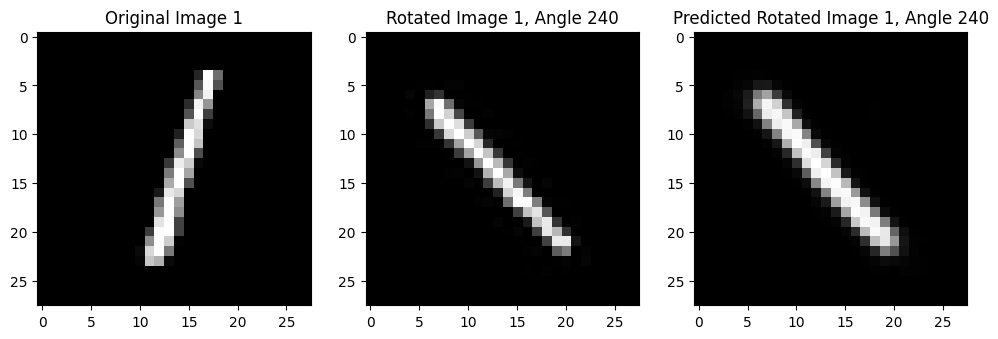

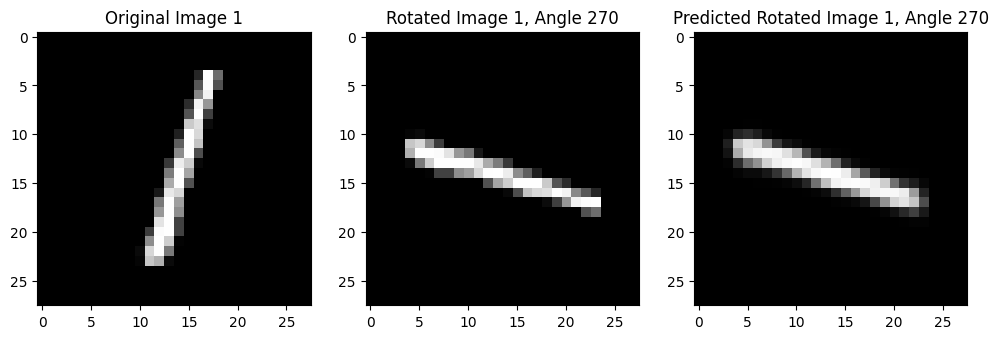

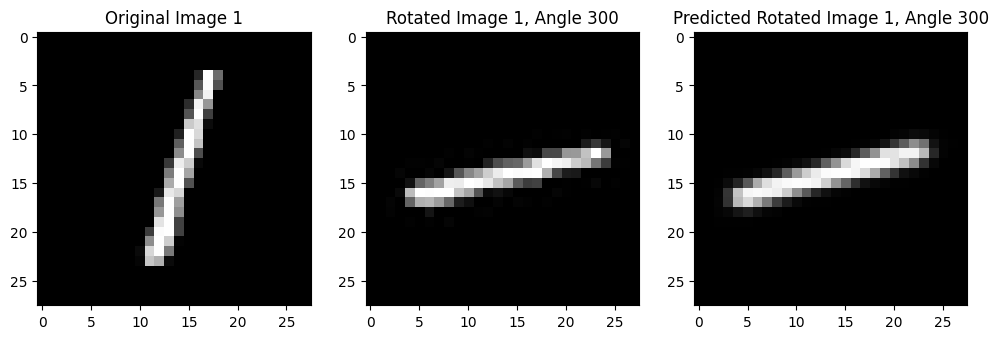

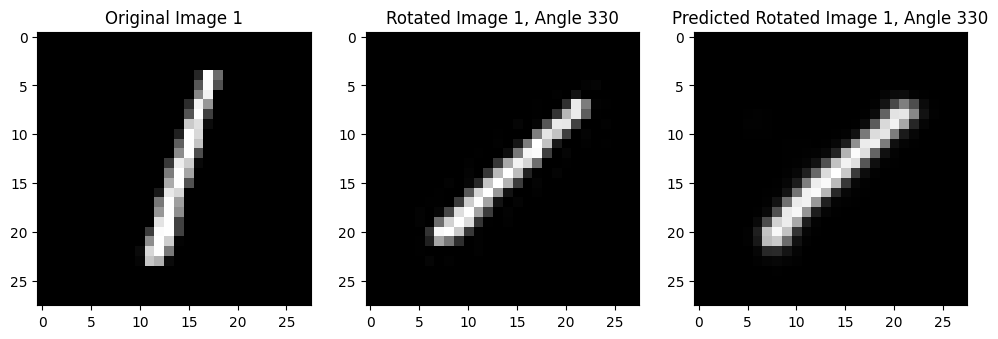

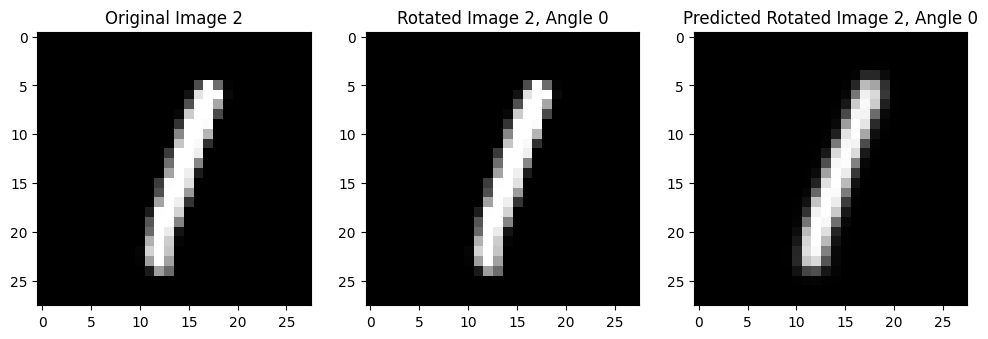

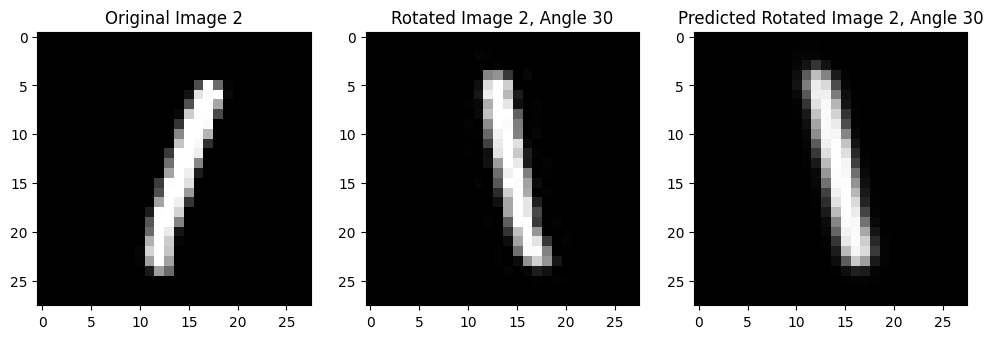

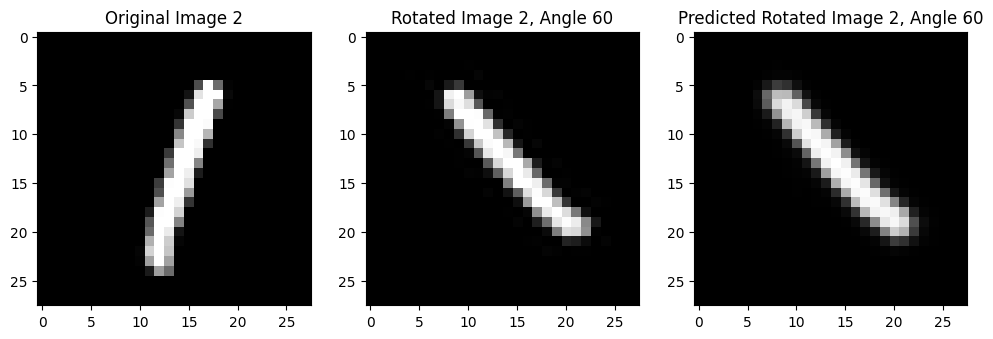

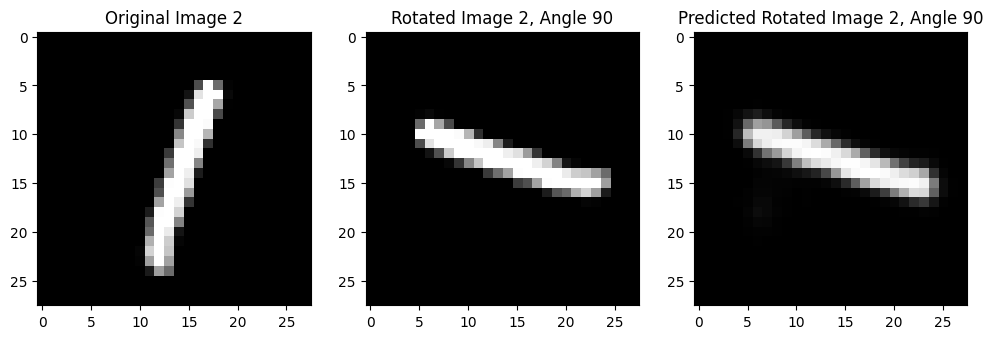

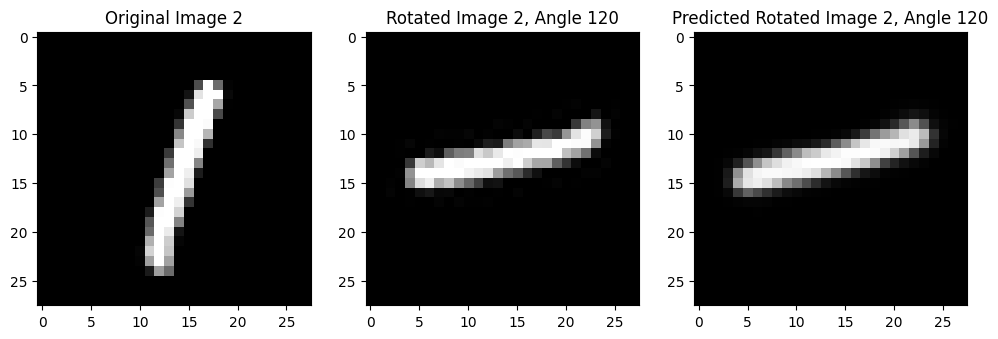

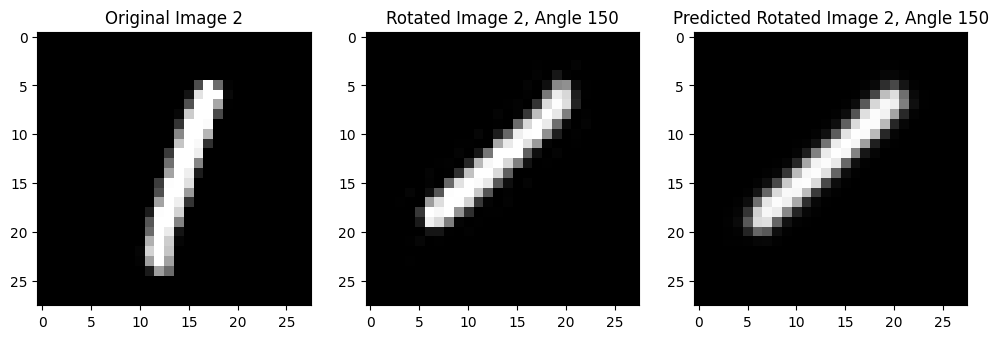

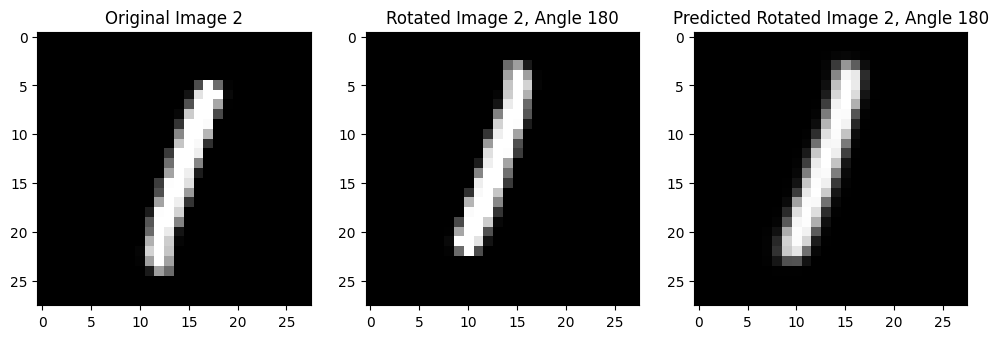

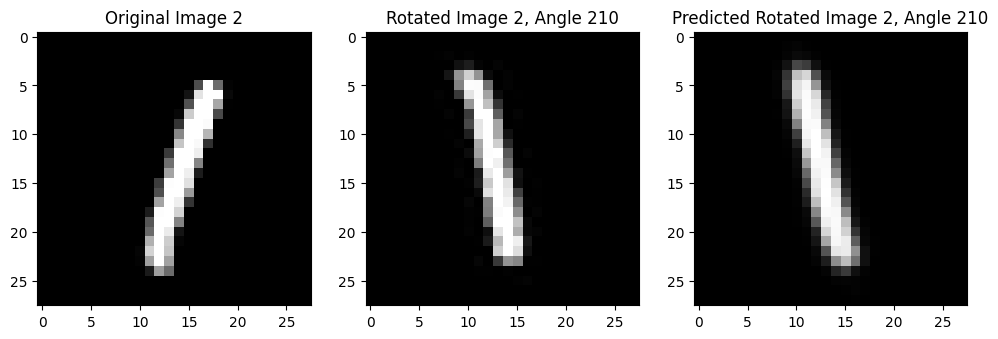

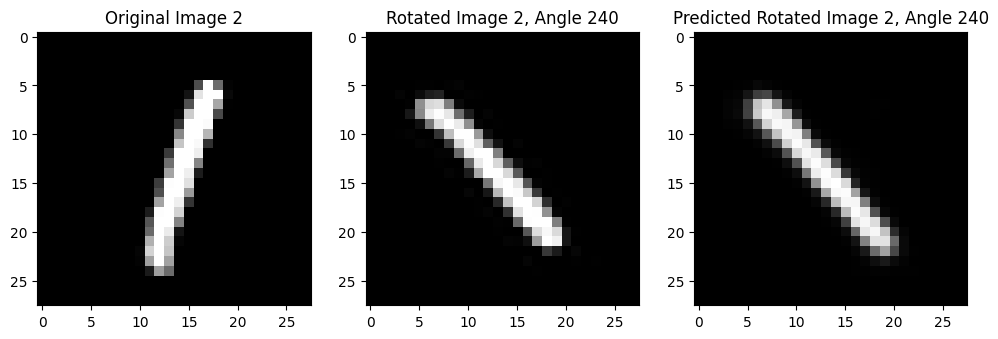

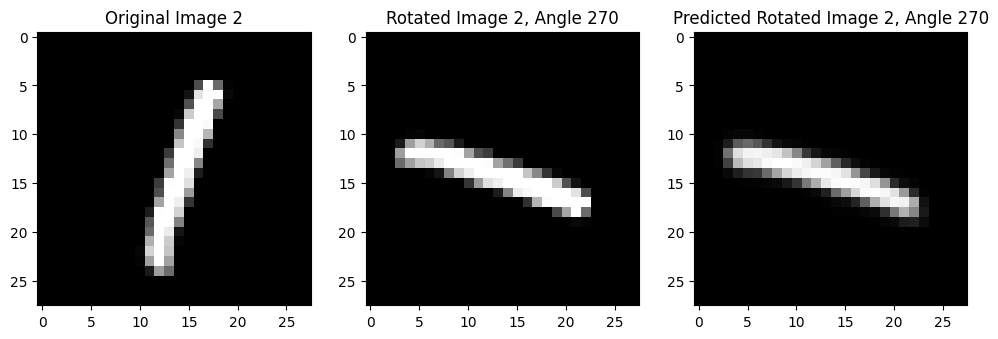

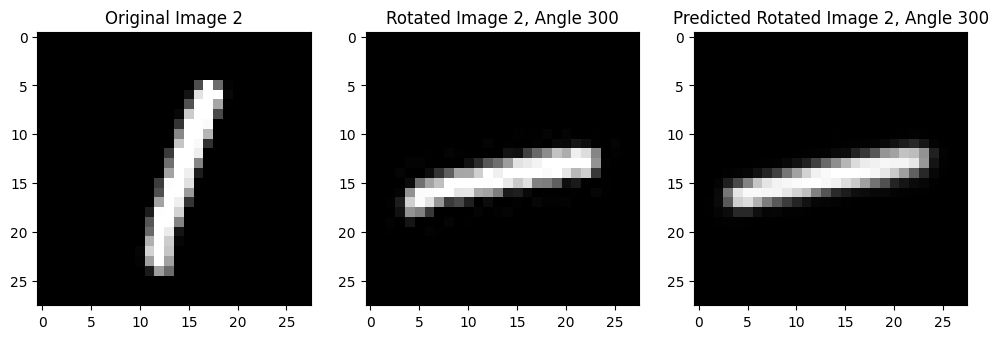

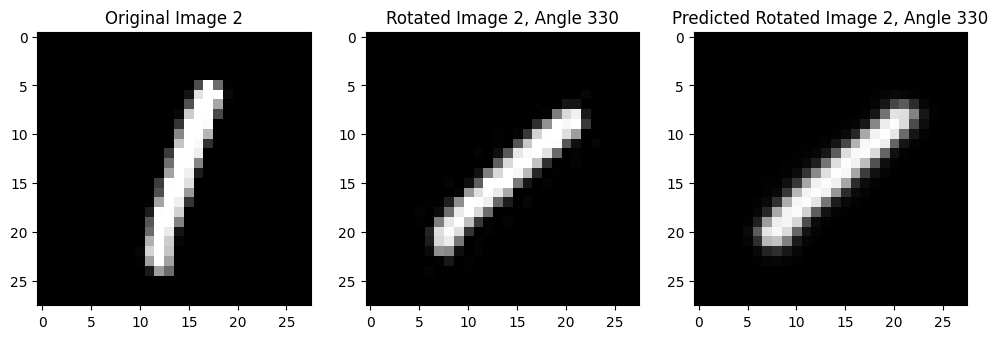

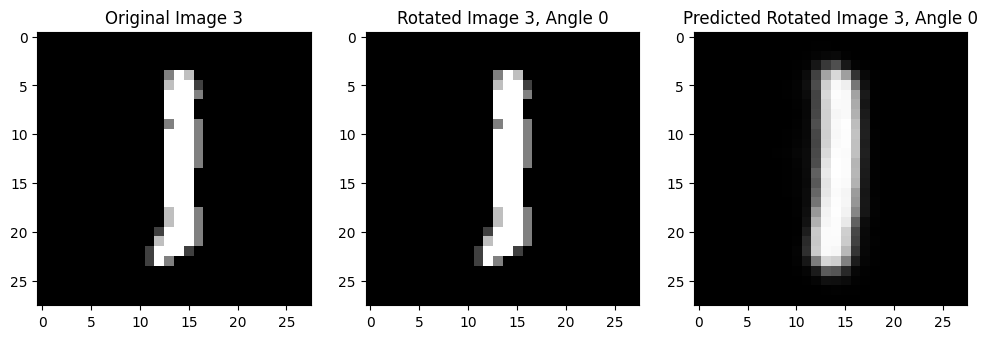

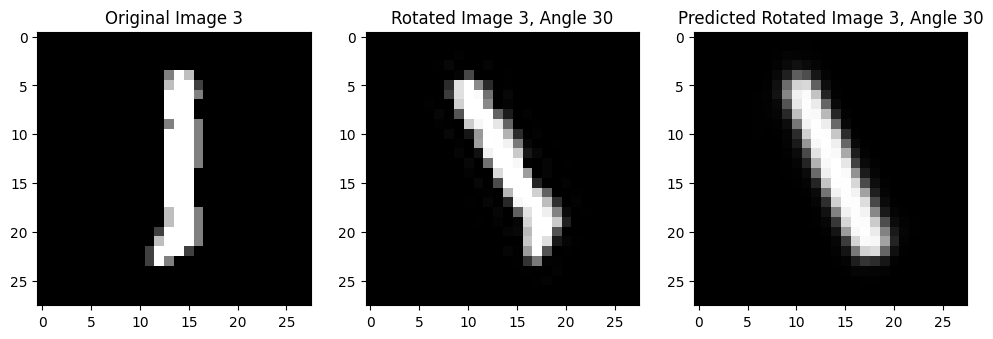

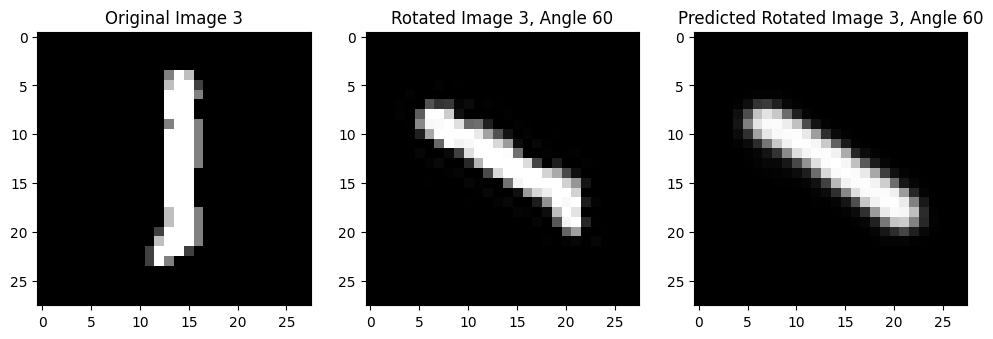

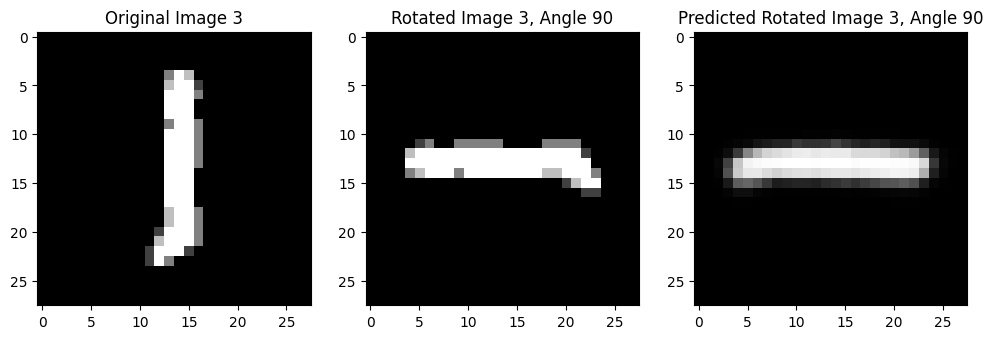

KeyboardInterrupt: 

In [31]:



selected_images = x_test[:10]


rotated_selected_images = rotate_images(selected_images, angles)


rotated_selected_images = rotated_selected_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0


z_original_example = vae.encoder.predict(rotated_selected_images)[2]

z_rotated_predicted = mlp.predict(z_original_example)


rotated_image_predicted = vae.decoder.predict(z_rotated_predicted)


for i in range(10):  # Loop through the selected images
    for j in range(12):  # Loop through all rotations
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(selected_images[i].squeeze(), cmap='gray')
        plt.title(f'Original Image {i}')

        plt.subplot(1, 3, 2)
        plt.imshow(rotated_selected_images[i * 12 + j].squeeze(), cmap='gray')  # Display the j-th rotation
        plt.title(f'Rotated Image {i}, Angle {angles[j]}')

        plt.subplot(1, 3, 3)
        plt.imshow(rotated_image_predicted[i * 12 + j].squeeze(), cmap='gray')  # Display the predicted j-th rotation
        plt.title(f'Predicted Rotated Image {i}, Angle {angles[j]}')

        plt.show()



In [17]:
!pip install tensorflow-addons

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate PSNR
psnr = tf.reduce_mean(tf.image.psnr(rotated_selected_images, vae.decoder.predict(vae.encoder.predict(rotated_selected_images)[2]), max_val=1.0))
print(f"VAE PSNR: {psnr.numpy()}")
num_samples = min(z_original_example.shape[0], z_rotated_predicted.shape[0])
latent_mse = tf.keras.losses.MeanSquaredError()(z_original_example[:num_samples], z_rotated_predicted[:num_samples])
print(f"MLP Latent Space MSE: {latent_mse.numpy()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
VAE PSNR: 21.38230323791504
MLP Latent Space MSE: 1.0226809978485107
